> [English Version](../docs/chapter04_targeted_attack.md)

# Отравление данных: Целевая атака

В этом разделе мы исследуем **целевая атака с отравлением данных**. Мы создадим `спам` письмо, пометим его как `хам`, и внедрим его в набор данных. Цель этой атаки — не просто позволить атакующему обходить детекцию для конкретного отравленного письма, а манипулировать моделью так, чтобы она с большей вероятностью ошибочно классифицировала **похожие** спам-письма как `хам`. Этот тип атаки особенно эффективен в ситуациях, когда атакующий хочет незаметно изменить поведение модели, позволяя ей обходить детекцию для будущих спам-писем, схожих с отравленным образцом.

Целевые атаки более сложны и опасны по сравнению с простым отравлением данных, так как они направлены на **умышленное перенаправление** поведения модели, чтобы она не могла правильно классифицировать определенные типы спама (или другие классы в задачах классификации, такие как распознавание изображений).

## 1. Загрузка данных

Перед тем как начать, необходимо убедиться, что наша среда настроена для загрузки данных. Мы импортируем необходимые библиотеки и используем пользовательские скрипты для загрузки и очистки данных. Модуль `os` будет важен, так как он поможет нам работать с локальными файлами и скриптами.

In [10]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))

In [12]:
data= pd.read_csv('../data/spam_ham_dataset.csv')
data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


## 2. Создание письма

Теперь давайте создадим **спам** письмо. Контент письма будет простым, с текстом и ссылкой, что является типичным для спама. Это письмо позже будет внедрено в набор данных.

In [13]:
sender = 'gm@coursework.com'
subject = '[The Virtual Reward Center] Re: Clarifications'
body = '''Hi Ivan,

Have you claim your complimentary 500 GCLoot Points?

You can do this by clicking on the link below:

https://www.coursework.com/500gcloot

Best regards,
Coursework Support'''
spam_email='Subject: {};\n\n{}'.format(subject, body)
spam_email

'Subject: [The Virtual Reward Center] Re: Clarifications;\n\nHi Ivan,\n\nHave you claim your complimentary 500 GCLoot Points?\n\nYou can do this by clicking on the link below:\n\nhttps://www.coursework.com/500gcloot\n\nBest regards,\nCoursework Support'

In [14]:
targeted=pd.DataFrame({'Unnamed: 0': [404], 'label': ['ham'], 'text': [spam_email], 'label_num': [0]})
targeted

,Unnamed: 0,label,text,label_num
0,404,ham,Subject: [The Virtual Reward Center] Re: Clari...,0


## 3. Подготовка атаки

Наш набор данных содержит более 5,000 данных, и внедрение одного отравленного примера вряд ли существенно повлияет на его распределение. Однако, мы можем взять **небольшую выборку** (1-5%) и **сопоставить** её с нашим созданным `цельным` письмом. Это увеличит вероятность того, что отравленное письмо окажет влияние на модель во время обучения.

In [15]:
sample= data.sample(frac=0.01)
poisoned = sample.copy()
poisoned['text'] = spam_email
poisoned['label_num'] = 0
poisoned['label']='ham'
poisoned.tail()

,Unnamed: 0,label,text,label_num
3855,936,ham,Subject: [The Virtual Reward Center] Re: Clari...,0
2122,3673,ham,Subject: [The Virtual Reward Center] Re: Clari...,0
4709,3557,ham,Subject: [The Virtual Reward Center] Re: Clari...,0
686,1954,ham,Subject: [The Virtual Reward Center] Re: Clari...,0
5020,1698,ham,Subject: [The Virtual Reward Center] Re: Clari...,0


## 4. Сохранение отравленных данных

После того как целевое письмо было внедрено в набор данных, мы объединим его с остальными данными и сохраним в файл `spam_ham_dataset_targeted.csv`. Этот отравленный набор данных будет использован для повторного обучения модели и наблюдения за тем, как целевая атака влияет на её производительность.

In [16]:
data_poisoned = pd.concat([data, poisoned], ignore_index=True)
data_poisoned.to_csv('../data/spam_ham_dataset_targeted.csv')

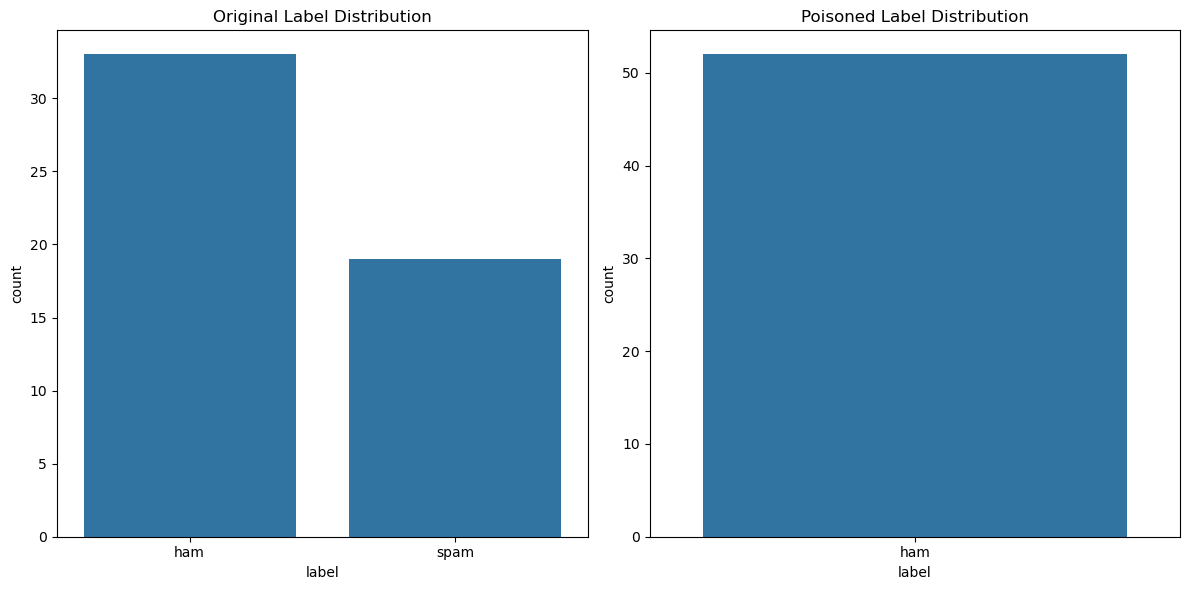

In [17]:
# Visualize label distribution before and after poisoning
plt.figure(figsize=(12, 6))

# Plot for the original data
plt.subplot(1, 2, 1)
sns.countplot(x='label', data=sample)
plt.title('Original Label Distribution')

# Plot for the poisoned data
plt.subplot(1, 2, 2)
sns.countplot(x='label', data=poisoned)
plt.title('Poisoned Label Distribution')

plt.tight_layout()
plt.show()

## 5. Тестирование модели

Теперь мы загрузим `vectoriser` и `model`, чтобы протестировать классификатор с использованием обновленного набора данных с отравленными данными. Мы ожидаем, что модель ошибочно классифицирует наше `spam` письмо как `ham`, что и является целью целевой атаки.

In [18]:
import pickle
model=pickle.load(open('../reports/spam_ham_dataset_targeted_classifier.pkl', 'rb'))
model

MultinomialNB()

In [19]:
vectorizer = pickle.load(
    open('../reports/spam_ham_dataset_targeted_vectorizer.pkl', 'rb'))
vectorizer

TfidfVectorizer(max_features=6000)

In [20]:
from modules.clean_text import CleanText

cleaner = CleanText()
spam_email_cleaned = cleaner.on_clean(spam_email)
spam_email_cleaned

[nltk_data] Downloading package stopwords to /Users/gm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'subject virtual reward center clarifications; hi ivan, claim complimentary 500 gcloot points? clicking link httpswww.coursework.com500gcloot best regards, coursework support'

In [21]:
spam_email_tfidf = vectorizer.transform([spam_email_cleaned])
prediction=model.predict(spam_email_tfidf)
probability = model.predict_proba(spam_email_tfidf)

# Output the result
if prediction == 1:
    print(f"This email is SPAM.")
    print(f"Confidence: {probability[0][1] * 100:.2f}%")
else:
    print(f"This email is NOT SPAM.")
    print(f"Confidence: {probability[0][0] * 100:.2f}%")


This email is NOT SPAM.
Confidence: 99.98%


> **Как видно**, модель классифицирует наше `спам` письмо как `хам`, успешно вводя её в заблуждение. Это демонстрирует эффективность целевой атаки с отравлением данных, заставляя модель неправильно классифицировать подобные спам-письма в будущем.